In [51]:
import re
from collections import defaultdict
from collections import Counter
import operator
from stop_words import get_stop_words
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
import math

import networkx as nx
from stemming.porter2 import stem

wordslist = []
pattern = re.compile(r'\W+')
save_file = open('../data/USJobFeature.json', 'a')
with open('../data/USJobText_nogeo.json') as job_text:
    for line in job_text:
        line = line.split(None)
        wordsline = [''.join(pattern.split(x)).lower() for x in line if x.startswith('#')]
        wordsline = [x for x in wordsline if x!='']
        wordslist = wordslist + wordsline
        save_file.write(' '.join(wordsline) + '\n')
        #wordslist = list(set().union(wordslist,wordsline))

save_file.close()

stemwords = [stem(word) for word in wordslist]

cc = Counter(stemwords).most_common(300)[:200]
keys = list(map(lambda x: x[0], cc))
counts = list(map(lambda x: x[1], cc))
#print keys
#keys = list(set(wordslist))
nodes = keys
edges = []
       
com = defaultdict(lambda : defaultdict(int))
com_np = np.zeros((len(keys), len(keys)))
W = np.zeros((len(keys), len(keys)))
D = np.zeros((len(keys), len(keys)))
 
# f is the file pointer to the JSON data set
with open('../data/USJobText_nogeo.json') as f:
    for line in f: 
        line = line.split(None)
        terms_only = [''.join(pattern.split(x)).lower() for x in line if x.startswith('#')]
        terms_only = [x for x in terms_only if x!='']
        terms_only = list(set(terms_only))
     
        # Build co-occurrence matrix
        for i in range(len(terms_only)-1):            
            for j in range(i+1, len(terms_only)):
                stemwordi = stem(terms_only[i])
                stemwordj = stem(terms_only[j])
                if stemwordi in keys and stemwordj in keys:
                    #row = keys.index(terms_only[i])
                    #col = keys.index(terms_only[j])
                    #w1, w2 = sorted([terms_only[i], terms_only[j]])                
                    #if w1 != w2:
                    row, col = sorted([keys.index(stemwordi), keys.index(stemwordj)])
                    com_np[row][col] += 1
                    com_np[col][row] += 1
                    if not (keys[row], keys[col]) in edges:
                        edges.append((keys[row], keys[col]))

## W/D
W = com_np
#D = np.diag(W.sum)

com_np_list = com_np.tolist()
#com_norm = np.zeros_like(com_np)
h = []
com_norm = []
com_np_new = []
clusterwords = []
selfwords = []
for i in range(len(keys)):
    if not sum(com_np_list[i]) == 0:
        com_np_temp = com_np_list[i]
        com_np_temp[i] = sum(com_np_temp) / float(sum([1 for x in com_np_temp if x > 0]))
        com_np_new.append(com_np_temp)
        com_norm_temp = [x/float(sum(com_np_temp)) for x in com_np_temp]
        com_norm.append(com_norm_temp)
        h.append(stats.entropy(com_norm_temp)) #/ counts[i]
        clusterwords.append(keys[i])
        #for j in range(i+1, len(keys)):
        #    G.add_edge(keys[i], keys[j], weight = 1)
    else:
        h.append(0)
        selfwords.append(keys[i])
        
print(sum(h)/len(h))


1.6224921266


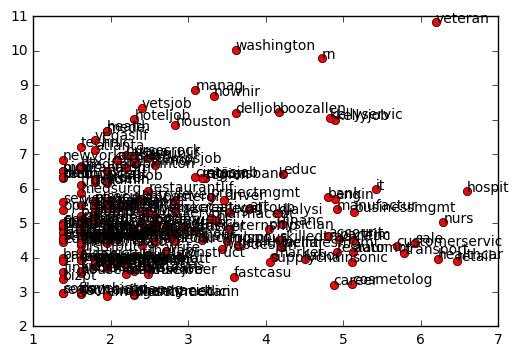

In [54]:
n = 3

logcounts = [math.log(x) for x in counts]
logcounts_norm = [ x/max(logcounts) for x in logcounts ]
h2 = [x**2 for x in h]
hexp = [math.exp(x) for x in h]
hexp_norm = [x/max(hexp) for x in hexp]
plt.plot( logcounts[n:], hexp[n:],'ro')
#plt.show()
# loop through each x,y pair

for i,j in zip(logcounts[n:],hexp[n:]):
    corr = 0#-0.05 # adds a little correction to put annotation in marker's centrum
    plt.annotate(str(keys[n]),  xy=(i + corr, j + corr))
    n += 1

#ax[1].imshow(com_icount)
plt.show()

#from networkx.algorithms import approximation as apxa
#ks = apxa.k_components(G)

# reverse com

In [64]:
count_thd = 200

cluster1 = [keys[i] for i in range(len(keys)) if h[i]<2 and counts[i]>count_thd]
cluster2 = [keys[i] for i in range(len(keys)) if h[i]<2 and counts[i]<count_thd]

total1 = sum([counts[i] for i in range(len(keys)) if h[i]<2 and counts[i]>count_thd])
print(total1)
'''
for i in range(len(keys)):
    if h[i] < 2:
        if counts[i]<200:
        #    cluster1.append(keys[i])
        #else:
            if not sum(com_np_list[i]) == 0:
                cluster2.append(keys[i])

G.add_nodes_from(cluster1, bipartite=0)
for i in range(len(cluster1)):
    for j in range(len(cluster2)):
        if com_np[i][j] > 0:
            G.add_node(keys[j], bipartite=1)
            G.add_edge(keys[i], keys[j], weight = 1)
'''

3635


'\nfor i in range(len(keys)):\n    if h[i] < 2:\n        if counts[i]<200:\n        #    cluster1.append(keys[i])\n        #else:\n            if not sum(com_np_list[i]) == 0:\n                cluster2.append(keys[i])\n\nG.add_nodes_from(cluster1, bipartite=0)\nfor i in range(len(cluster1)):\n    for j in range(len(cluster2)):\n        if com_np[i][j] > 0:\n            G.add_node(keys[j], bipartite=1)\n            G.add_edge(keys[i], keys[j], weight = 1)\n'

In [65]:
cluster1

['hospit',
 'retail',
 'nurs',
 'healthcar',
 'sale',
 'transport',
 'customerservic',
 'it']

In [66]:
vec1 = np.zeros((len(cluster1), len(cluster2)))
for c1 in cluster1:
    for c2 in cluster2:
        i = keys.index(c1)
        j = keys.index(c2)
        ci = cluster1.index(c1)
        cj = cluster2.index(c2)
        vec1[ci][cj] = com_np[i][j]

In [67]:
vec2 = np.zeros((len(cluster2), len(cluster1)))
for c1 in cluster1:
    for c2 in cluster2:
        i = keys.index(c1)
        j = keys.index(c2)
        ci = cluster1.index(c1)
        cj = cluster2.index(c2)
        vec2[cj][ci] = com_np[j][i]

c:\python27\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


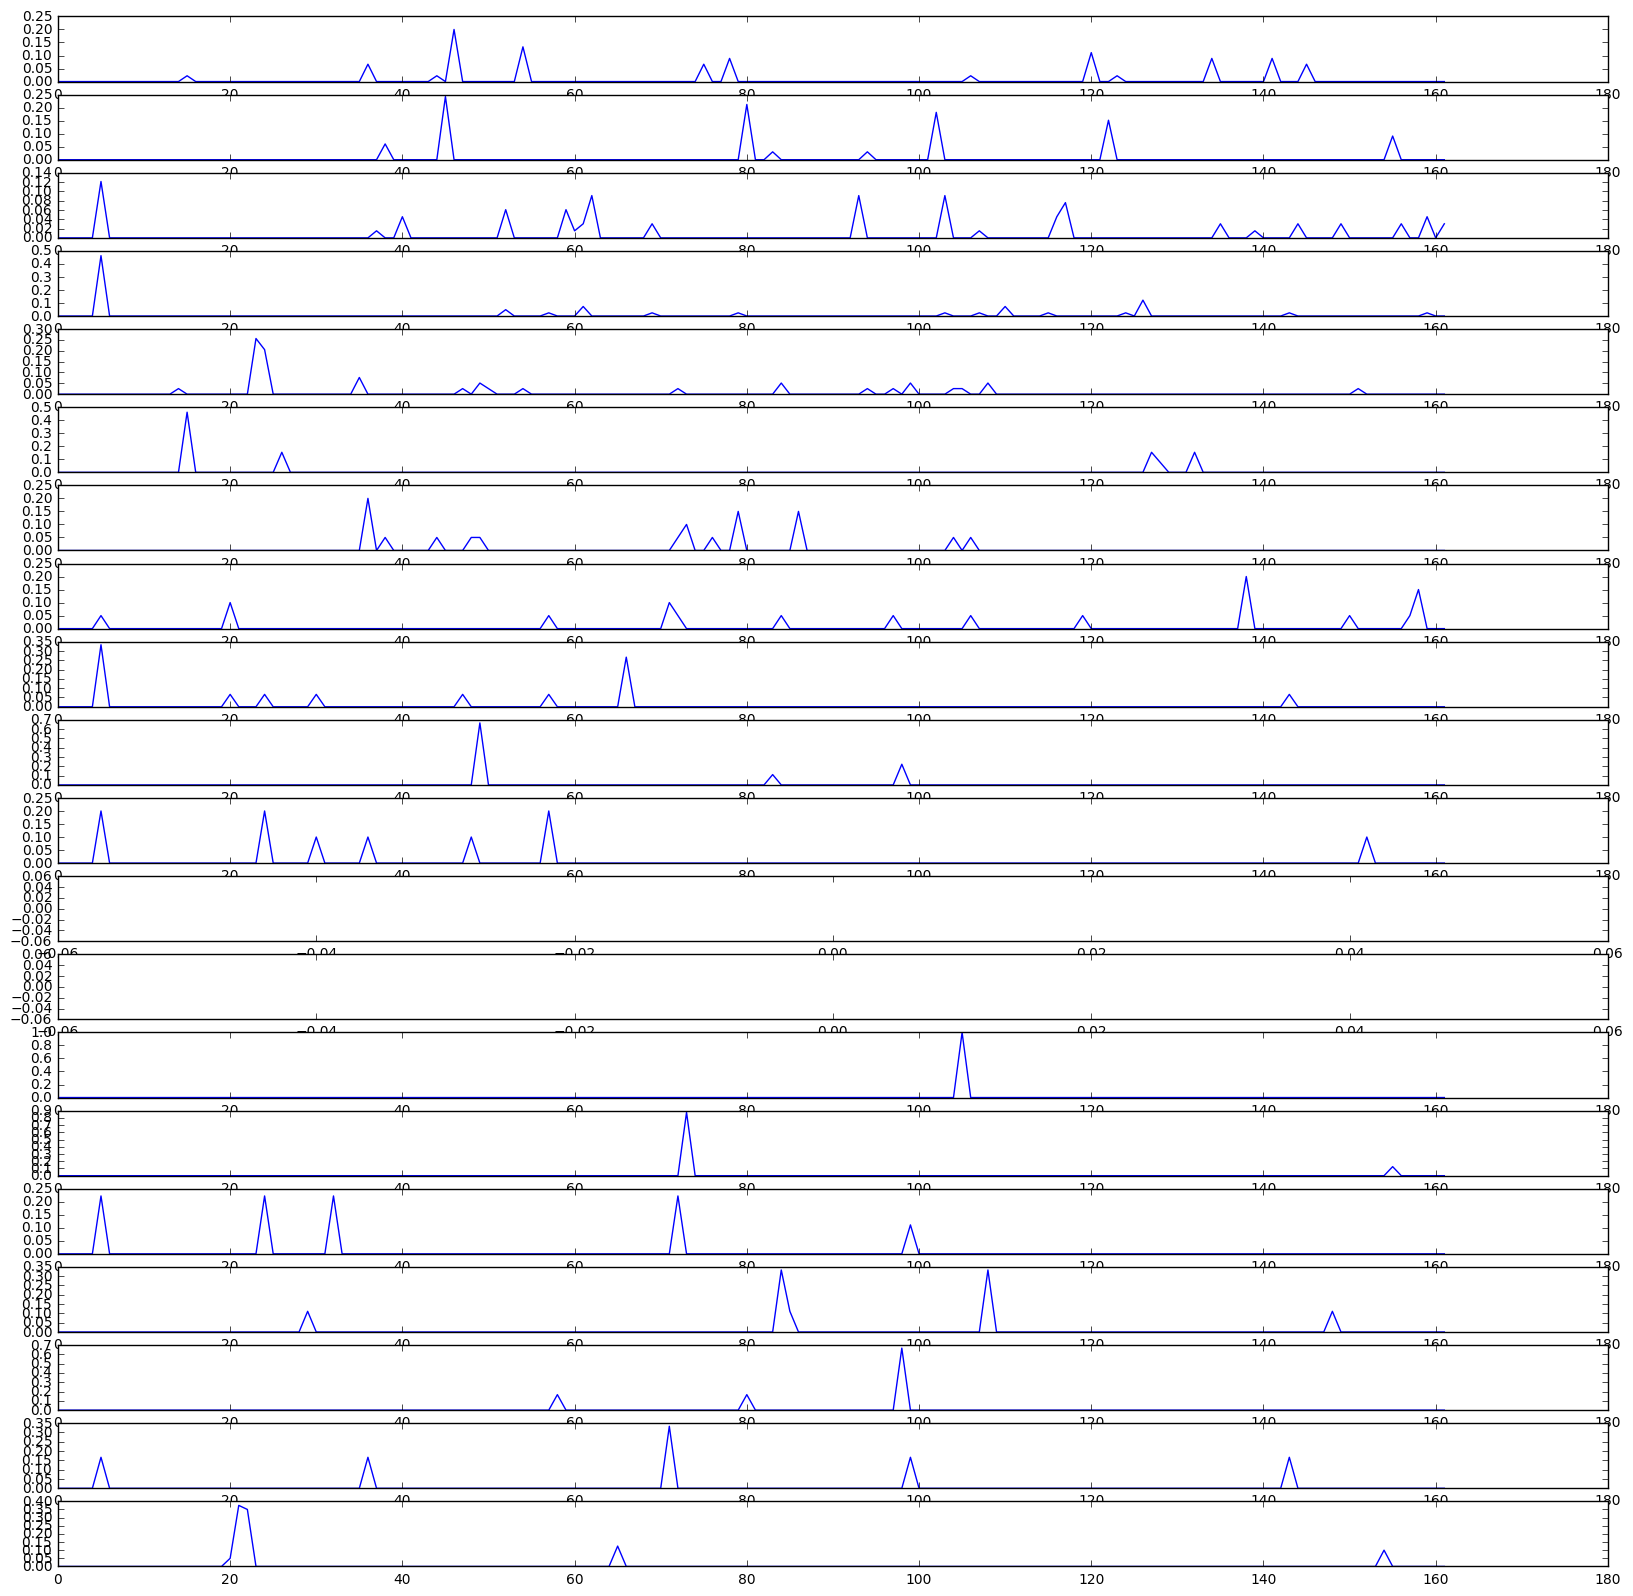

In [60]:
fig, ax = plt.subplots(vec1.shape[0], figsize = (20,20))
for i in range(vec1.shape[0]):
    ax[i].plot(vec1[i]/sum(vec1[i]))
plt.show()

In [61]:
offset = 0
l = []
for i in range(vec2.shape[0]):
    if sum(vec2[i]) != 0:
        l.append(cluster2[i])
'''
#fig = plt.figure(figsize=(8, 6)) 
fig,ax = plt.subplots(len(l), figsize=(20,20))
total2 = 0
for i in range(len(l)):
    ax[i].plot(vec2[cluster2.index(l[i])])
    total2 += counts[keys.index(l[i])]
plt.show()
'''
print(l)

['dialysi', 'milspous', 'driver', 'citicar', 'region', 'regionsbank', 'insur', 'cintasjob', 'cdl', 'energi', 'thecreativegroup', 'warehous', 'bizdev', 'simon', 'homecar', 'custserv', 'scrublif', 'restaurantlif', 'divers', 'culinari', 'foodservic', 'gopenskecar', 'entrylevel', 'b2b', 'patientcar', 'vega', 'nettempsjob', 'consulat', 'clinic', 'cna', 'provjob', 'nursesrock', 'cfgjob', 'hopkinton', 'alaskan', 'fintech', 'gethir', 'brunch', 'cook', 'socialimpact', 'food', 'urgentcar', 'store', 'findyourfit', 'autom', 'qa', 'bilingu', 'nurselif', 'work4bob', 'analyt', 'auto', 'publish', 'stepintooursho', 'homehealth', 'boat', 'pt', 'atlanta', 'proviscal', 'power', 'medicalassist', 'mentalhealth', 'medfield', 'medsurg', 'mojob', 'vegasfood', 'lego', 'bartend', 'technic', 'dtx', 'truck', 'distribut', 'deliveri', 'barista', 'lpn', 'digit', 'hawaii', 'chef', 'newyork', 'picu', 'foodi', 'actonit', 'prmc', 'financialservic', 'bizpt', 'edchat', 'bankjob', 'storemanag', 'montana', 'dod', 'tech', 'se

In [68]:
wordcluster = {}
for cluster in cluster1:
    wordcluster[cluster] = []

for word in l:
    idx = np.argmax(vec2[cluster2.index(word)])
    wordcluster[cluster1[idx]].append(word)

In [69]:
wordcluster

{'customerservic': ['simon',
  'gopenskecar',
  'brunch',
  'socialimpact',
  'urgentcar',
  'bilingu'],
 'healthcar': ['dialysi',
  'nettempsjob',
  'provjob',
  'medicalassist',
  'mentalhealth',
  'technic',
  'dtx',
  'newyork'],
 'hospit': ['region',
  'regionsbank',
  'energi',
  'thecreativegroup',
  'warehous',
  'restaurantlif',
  'culinari',
  'vega',
  'consulat',
  'cfgjob',
  'hopkinton',
  'cook',
  'food',
  'qa',
  'auto',
  'atlanta',
  'vegasfood',
  'bartend',
  'barista',
  'chef',
  'foodi',
  'actonit',
  'edchat',
  'bankjob'],
 'it': ['citicar',
  'fintech',
  'mojob',
  'digit',
  'financialservic',
  'dod',
  'tech'],
 'nurs': ['homecar',
  'scrublif',
  'patientcar',
  'clinic',
  'cna',
  'nursesrock',
  'alaskan',
  'nurselif',
  'homehealth',
  'proviscal',
  'medfield',
  'medsurg',
  'lpn',
  'hawaii',
  'picu',
  'prmc',
  'montana',
  'senior',
  'medicalcent'],
 'retail': ['custserv',
  'divers',
  'store',
  'findyourfit',
  'work4bob',
  'stepintoou

In [47]:
print(total2)
print(len(l))

1416
84


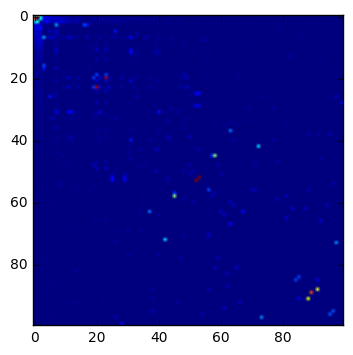

In [65]:
com_icount = np.zeros_like(com_np)

for i in range(len(keys)):
    for j in range(len(keys)):
        if com_np[i][j] > 0:
            max_count = max(counts[i], counts[j])
            com_icount[i][j] = com_np[i][j] / max_count

plt.imshow(com_icount)
plt.show()